<a href="https://colab.research.google.com/github/raditzad/contract-prolongation-analytics/blob/main/prolongation_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from io import BytesIO

# Visualization settings
plt.style.use('ggplot')
sns.set_context("notebook")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

def read_csv_from_gdrive(file_id):
    """Download CSV from Google Drive into memory."""
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(BytesIO(response.content))
    else:
        raise Exception(f"Failed to download file: {file_id}")

def clean_currency(x):
    """Convert string currency to float, preserving flags."""
    if pd.isna(x): return 0.0
    x_str = str(x).lower().strip()

    if 'стоп' in x_str or 'end' in x_str: return 'STOP_FLAG'
    if 'ноль' in x_str or 'zero' in x_str: return 'ZERO_FLAG'

    if any(char.isdigit() for char in x_str):
        clean_val = re.sub(r'\s+', '', x_str).replace(',', '.')
        try:
            return float(clean_val)
        except ValueError:
            return 0.0
    return 0.0

In [2]:
FINANCIAL_DATA_ID = '1r3grFMz_k-XuWhRNLOAZCoLDdVYg2C7X'
PROLONGATIONS_ID = '1n2CIsPZYOIqMfV7b3aUtp1efc9U96xVt'

print("Downloading data...")
financial_data = read_csv_from_gdrive(FINANCIAL_DATA_ID)
prolongations = read_csv_from_gdrive(PROLONGATIONS_ID)

print(f"Financial Data: {financial_data.shape}")
print(f"Prolongations Data: {prolongations.shape}")

# Identify month columns dynamically (excluding metadata)
month_columns = [col for col in financial_data.columns if col not in ['id', 'Причина дубля', 'Account']]
print(f"Month columns found: {len(month_columns)}")

Financial Data: (451, 19)
Prolongations Data: (477, 3)
Month columns found: 16


In [3]:
# 1. Normalize text to lower case for consistent matching
financial_data.columns = [c.lower().strip() if c in month_columns else c for c in financial_data.columns]
prolongations['month'] = prolongations['month'].str.lower().str.strip()
month_columns = [c.lower().strip() for c in month_columns]

# 2. Remove Terminated Projects ('STOP'/'END')
def remove_stop_projects(df, cols):
    stop_mask = df[cols].astype(str).apply(
        lambda x: x.str.contains('стоп|end', case=False, na=False)
    ).any(axis=1)
    stop_ids = df.loc[stop_mask, 'id'].unique()
    return df[~df['id'].isin(stop_ids)].copy()

finance_clean = remove_stop_projects(financial_data, month_columns)

# 3. Apply currency cleaning
for col in month_columns:
    finance_clean[col] = finance_clean[col].apply(clean_currency)

print("Data cleaning complete.")

Data cleaning complete.


In [4]:
# Sum partial payments for the same ID BEFORE handling 'Zero' logic
def safe_sum_agg(series):
    nums = [x for x in series if isinstance(x, (int, float))]
    total = sum(nums)
    # If total is 0 but input had 'ZERO_FLAG', preserve it
    if total == 0 and 'ZERO_FLAG' in series.values:
        return 'ZERO_FLAG'
    return total

agg_rules = {col: safe_sum_agg for col in month_columns}
agg_rules['Account'] = 'first'

finance_agg = finance_clean.groupby('id').agg(agg_rules).reset_index()
print(f"Unique Projects after aggregation: {len(finance_agg)}")

Unique Projects after aggregation: 259


In [5]:
# Define chronological order for lookups
month_map = {
    'ноябрь 2022': 0, 'декабрь 2022': 1,
    'январь 2023': 2, 'февраль 2023': 3, 'март 2023': 4,
    'апрель 2023': 5, 'май 2023': 6, 'июнь 2023': 7,
    'июль 2023': 8, 'август 2023': 9, 'сентябрь 2023': 10,
    'октябрь 2023': 11, 'ноябрь 2023': 12, 'декабрь 2023': 13,
    'январь 2024': 14, 'февраль 2024': 15
}

sorted_cols = sorted([c for c in month_columns if c in month_map], key=lambda x: month_map[x])

def resolve_zeros(row):
    for i, month in enumerate(sorted_cols):
        if row[month] == 'ZERO_FLAG' or row[month] == 0.0:
            if i > 0:
                prev_val = row[sorted_cols[i-1]]
                if isinstance(prev_val, (int, float)):
                    row[month] = prev_val
                else:
                    row[month] = 0.0
            else:
                row[month] = 0.0
    return row

finance_final = finance_agg.apply(resolve_zeros, axis=1)

# Final numeric conversion
for col in sorted_cols:
    finance_final[col] = pd.to_numeric(finance_final[col], errors='coerce').fillna(0.0)

In [13]:
# --- Cell 6: Department KPI Calculation ---

months_2023 = [
    'январь 2023', 'февраль 2023', 'март 2023', 'апрель 2023',
    'май 2023', 'июнь 2023', 'июль 2023', 'август 2023',
    'сентябрь 2023', 'октябрь 2023', 'ноябрь 2023', 'декабрь 2023'
]

results = []

def get_prev(curr):
    try:
        idx = sorted_cols.index(curr)
        return sorted_cols[idx-1] if idx > 0 else None
    except: return None

for curr in months_2023:
    if curr not in sorted_cols: continue
    prev = get_prev(curr)
    if not prev: continue
    prev_prev = get_prev(prev)

    # --- K1 Calculation ---
    # Base: Projects ended in prev month
    ids_k1 = prolongations[prolongations['month'] == prev]['id'].unique()
    data_k1 = finance_final[finance_final['id'].isin(ids_k1)]

    base_k1 = data_k1[prev].sum()
    fact_k1 = data_k1[curr].sum()
    k1 = fact_k1 / base_k1 if base_k1 > 0 else 0.0

    # --- K2 Calculation ---
    k2 = 0.0
    base_k2 = 0
    fact_k2 = 0

    if prev_prev:
        # Base: Projects ended 2 months ago
        ids_k2 = prolongations[prolongations['month'] == prev_prev]['id'].unique()
        data_k2 = finance_final[finance_final['id'].isin(ids_k2)]

        # Filter: Only those NOT prolonged in 1st month (revenue in month 1 == 0)
        # Using a small epsilon for float safety, though == 0 usually works for cleaned data
        not_prolonged = data_k2[data_k2[prev] <= 0.01]

        base_k2 = not_prolonged[prev_prev].sum()
        fact_k2 = not_prolonged[curr].sum()
        k2 = fact_k2 / base_k2 if base_k2 > 0 else 0.0

    results.append({
        'Month': curr,
        'K1': k1, 'K2': k2,
        'K1_Base': base_k1, 'K1_Fact': fact_k1,
        'K2_Base': base_k2, 'K2_Fact': fact_k2
    })

df_dept = pd.DataFrame(results)

# --- Yearly Weighted Average (Safe Division) ---
total_base_k1 = df_dept['K1_Base'].sum()
total_fact_k1 = df_dept['K1_Fact'].sum()

total_base_k2 = df_dept['K2_Base'].sum()
total_fact_k2 = df_dept['K2_Fact'].sum()

yearly_k1 = (total_fact_k1 / total_base_k1) if total_base_k1 > 0 else 0.0
yearly_k2 = (total_fact_k2 / total_base_k2) if total_base_k2 > 0 else 0.0

print(f"Yearly K1: {yearly_k1:.2%}")
print(f"Yearly K2: {yearly_k2:.2%}")
print(f"Debug K2 Base Total: {total_base_k2}") # Чтобы проверить, действительно ли база 0

Yearly K1: 98.11%
Yearly K2: 0.00%
Debug K2 Base Total: 0.0


In [14]:
# Creating the Manager Report
manager_stats = []

for manager in prolongations['AM'].unique():
    # Filter projects for this manager
    mgr_ids = prolongations[prolongations['AM'] == manager]['id'].unique()
    mgr_fin = finance_final[finance_final['id'].isin(mgr_ids)]
    mgr_prol = prolongations[prolongations['AM'] == manager]

    # Accumulators for yearly weighted average
    k1_base_sum = 0
    k1_fact_sum = 0
    k2_base_sum = 0
    k2_fact_sum = 0

    # Iterate months to calculate manager sums
    for curr in months_2023:
        if curr not in sorted_cols: continue
        prev = get_prev(curr)
        if not prev: continue
        prev_prev = get_prev(prev)

        # K1 Logic per Manager
        ids_end_prev = mgr_prol[mgr_prol['month'] == prev]['id']
        subset_k1 = mgr_fin[mgr_fin['id'].isin(ids_end_prev)]
        k1_base_sum += subset_k1[prev].sum()
        k1_fact_sum += subset_k1[curr].sum()

        # K2 Logic per Manager
        if prev_prev:
            ids_end_pre_prev = mgr_prol[mgr_prol['month'] == prev_prev]['id']
            subset_k2 = mgr_fin[mgr_fin['id'].isin(ids_end_pre_prev)]
            # Filter those failed in month 1
            subset_k2 = subset_k2[subset_k2[prev] == 0]
            k2_base_sum += subset_k2[prev_prev].sum()
            k2_fact_sum += subset_k2[curr].sum()

    # Calculate weighted annual KPIs
    mgr_k1 = (k1_fact_sum / k1_base_sum) if k1_base_sum > 0 else 0.0
    mgr_k2 = (k2_fact_sum / k2_base_sum) if k2_base_sum > 0 else 0.0

    manager_stats.append({
        'Manager': manager,
        'Yearly_K1': mgr_k1,
        'Yearly_K2': mgr_k2,
        'Total_Projects': len(mgr_ids),
        'Volume_Base_K1': k1_base_sum,
        'Volume_Prolonged_K1': k1_fact_sum
    })

df_managers = pd.DataFrame(manager_stats).sort_values('Yearly_K1', ascending=False)

print("Manager Ratings:")
display(df_managers[['Manager', 'Yearly_K1', 'Yearly_K2', 'Total_Projects']])

Manager Ratings:


,Manager,Yearly_K1,Yearly_K2,Total_Projects
8,Петрова Анна Дмитриевна,1.11,0.00,1
5,Смирнова Ольга Владимировна,1.04,0.00,53
6,Кузнецов Михаил Иванович,1.02,0.00,17
2,Соколова Анастасия Викторовна,1.01,0.00,60
0,Васильев Артем Александрович,1.00,0.00,92
1,Михайлов Андрей Сергеевич,0.98,0.00,24
4,Попова Екатерина Николаевна,0.97,0.00,58
3,Иванова Мария Сергеевна,0.86,0.00,42
7,без А/М,0.00,0.00,2
9,Федорова Марина Васильевна,0.00,0.00,2


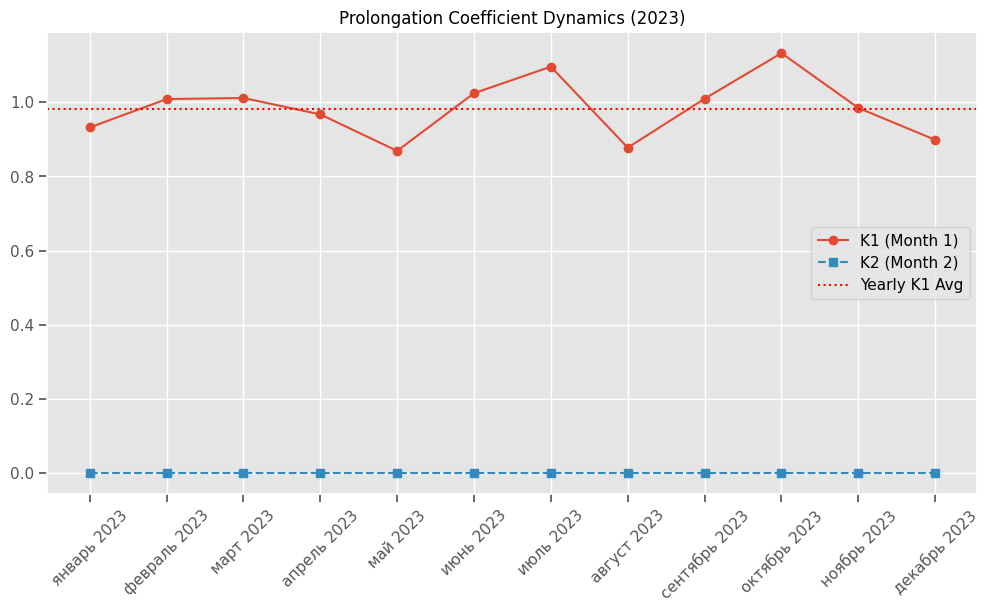

In [8]:
# 1. Department Dynamics
plt.figure(figsize=(12, 6))
plt.plot(df_dept['Month'], df_dept['K1'], marker='o', label='K1 (Month 1)')
plt.plot(df_dept['Month'], df_dept['K2'], marker='s', label='K2 (Month 2)', linestyle='--')
plt.axhline(yearly_k1, color='red', linestyle=':', label='Yearly K1 Avg')
plt.title('Prolongation Coefficient Dynamics (2023)')
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [10]:
# Creating Manager Statistics for Visualization
manager_stats = []

for manager in prolongations['AM'].unique():
    # Projects associated with this manager
    mgr_ids = prolongations[prolongations['AM'] == manager]['id'].unique()
    mgr_fin = finance_final[finance_final['id'].isin(mgr_ids)]
    mgr_prol = prolongations[prolongations['AM'] == manager]

    # Calculate Totals for Weighted Average
    k1_base_total = 0
    k1_fact_total = 0

    prolonged_count = 0 # Count of successful projects

    for curr in months_2023:
        if curr not in sorted_cols: continue
        prev = get_prev(curr)
        if not prev: continue

        # K1 Logic
        ids_end_prev = mgr_prol[mgr_prol['month'] == prev]['id']
        subset_k1 = mgr_fin[mgr_fin['id'].isin(ids_end_prev)]

        k1_base_total += subset_k1[prev].sum()
        k1_fact_total += subset_k1[curr].sum()

        # Count prolonged projects (where revenue > 0 in month 1)
        prolonged_count += (subset_k1[curr] > 0).sum()

    mgr_k1 = (k1_fact_total / k1_base_total) if k1_base_total > 0 else 0.0

    manager_stats.append({
        'Manager': manager,
        'Yearly_K1': mgr_k1,
        'Total_Projects': len(mgr_ids),
        'Prolonged_Projects': prolonged_count,
        'Total_Base_Sum': k1_base_total,
        'Total_Prolonged_Sum': k1_fact_total
    })

df_mgr = pd.DataFrame(manager_stats).sort_values('Total_Projects', ascending=True) # Sort for horizontal bar chart

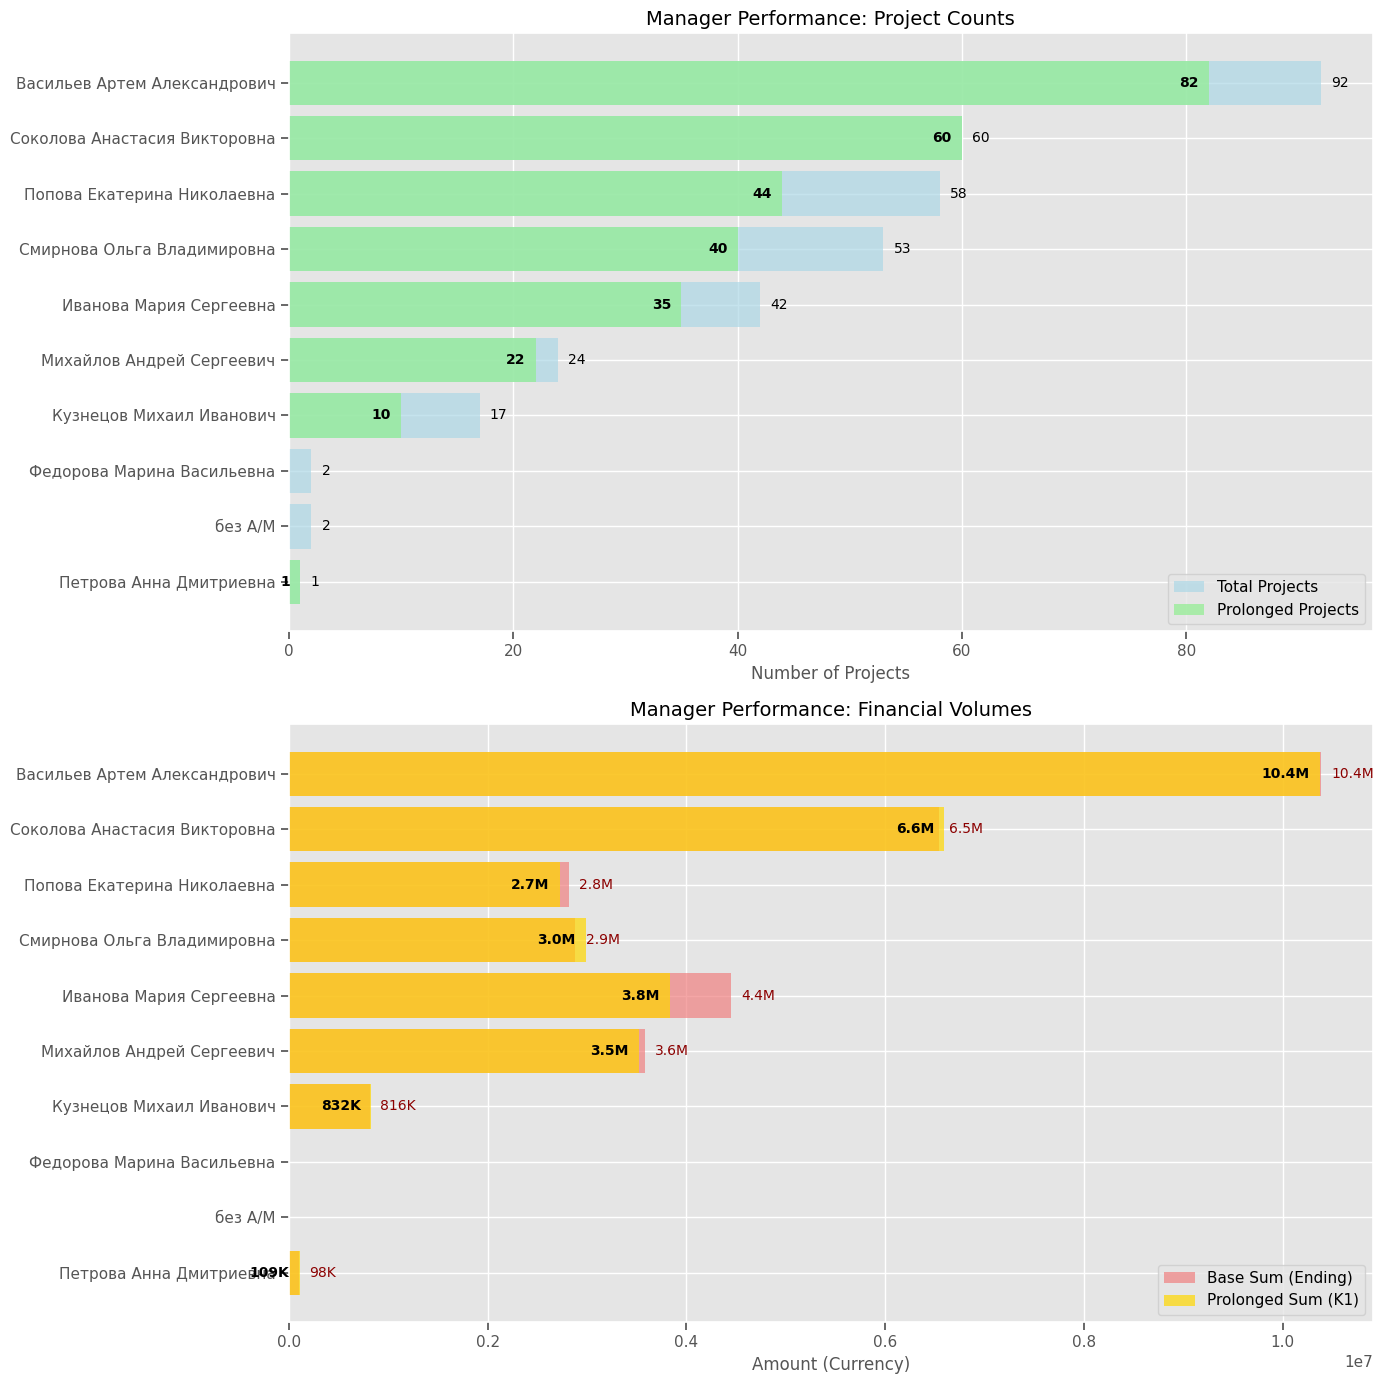

In [12]:
# Set up figure with 2 subplots (Increased height for better spacing)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# --- Chart 1: Project Counts (Total vs Prolonged) ---
# Sorting by Total Projects for better visual hierarchy
df_mgr_sorted = df_mgr.sort_values('Total_Projects', ascending=True)
y_pos = np.arange(len(df_mgr_sorted))

ax1.barh(y_pos, df_mgr_sorted['Total_Projects'], color='lightblue', alpha=0.7, label='Total Projects')
ax1.barh(y_pos, df_mgr_sorted['Prolonged_Projects'], color='lightgreen', alpha=0.7, label='Prolonged Projects')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_mgr_sorted['Manager'])
ax1.set_xlabel('Number of Projects', fontsize=12)
ax1.set_title('Manager Performance: Project Counts', fontsize=14)
ax1.legend(loc='lower right')

# Add labels safely
max_proj = df_mgr_sorted['Total_Projects'].max()
offset_proj = max_proj * 0.01

for i, (total, prol) in enumerate(zip(df_mgr_sorted['Total_Projects'], df_mgr_sorted['Prolonged_Projects'])):
    # Label for Total (at the end of blue bar)
    ax1.text(total + offset_proj, i, str(total), va='center', fontsize=10, color='black')

    # Label for Prolonged (inside or near green bar)
    # Only show if > 0 to avoid clutter
    if prol > 0:
        # If bar is too small, put label slightly outside
        x_pos = prol - offset_proj if prol > total * 0.1 else prol + offset_proj
        color = 'black' # Always black for readability
        ax1.text(x_pos, i, str(prol), va='center', ha='right' if prol > total * 0.1 else 'left', fontsize=10, color=color, fontweight='bold')

# --- Chart 2: Financial Volumes (Base vs Prolonged) ---
# We use the same sorted order to match the first chart
ax2.barh(y_pos, df_mgr_sorted['Total_Base_Sum'], color='lightcoral', alpha=0.7, label='Base Sum (Ending)')
ax2.barh(y_pos, df_mgr_sorted['Total_Prolonged_Sum'], color='gold', alpha=0.7, label='Prolonged Sum (K1)')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(df_mgr_sorted['Manager'])
ax2.set_xlabel('Amount (Currency)', fontsize=12)
ax2.set_title('Manager Performance: Financial Volumes', fontsize=14)
ax2.legend(loc='lower right')

# Helper for large numbers
def fmt_num(x):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.0f}K'
    return f'{int(x)}'

# Smart Label Placement to avoid overlapping
max_val = df_mgr_sorted['Total_Base_Sum'].max()
offset = max_val * 0.01

for i, (base, fact) in enumerate(zip(df_mgr_sorted['Total_Base_Sum'], df_mgr_sorted['Total_Prolonged_Sum'])):
    # Label for Base Sum (Red bar) - always at the end
    if base > 0:
        ax2.text(base + offset, i, fmt_num(base), va='center', fontsize=10, color='darkred')

    # Label for Prolonged Sum (Yellow bar)
    if fact > 0:
        # Check if bars are too close in length (overlap risk)
        # If Fact is > 85% of Base, place Fact label INSIDE the bar to the left
        if fact > base * 0.85:
            ax2.text(fact - offset, i, fmt_num(fact), va='center', ha='right', fontsize=10, color='black', fontweight='bold')
        else:
            # Otherwise place it just after the yellow bar
            ax2.text(fact + offset, i, fmt_num(fact), va='center', ha='left', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()